## Installation and Imports

In [40]:
%pip install pddlpy networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip uninstall fsspec
%pip install fsspec==2024.10.0

Found existing installation: fsspec 2024.9.0
Uninstalling fsspec-2024.9.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/fsspec-2024.9.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/fsspec/*
Proceed (Y/n)? Y
  Successfully uninstalled fsspec-2024.9.0
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.1.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.


In [2]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.isomorphism import GraphMatcher
from pddlpy import DomainProblem
import pandas as pd
import numpy as np

## Sample record processing

In [3]:
df = pd.read_parquet("hf://datasets/BatsResearch/planetarium/data/train-00000-of-00001.parquet")

In [4]:
list(df.keys())

['id',
 'name',
 'domain',
 'init',
 'goal',
 'num_objects',
 'problem_pddl',
 'natural_language',
 'init_is_abstract',
 'init_num_propositions',
 'goal_is_abstract',
 'goal_num_propositions',
 'is_placeholder',
 'split']

In [12]:
#output_dir = "/content/"
output_dir = "/home/asivak21/plai project/"
sample = df.loc[0]
print("sample problem domain: ", sample['domain'])
problem_pddl = sample['problem_pddl']
problem_file = os.path.join(output_dir, f'sample_problem_groundtruth.pddl')

with open(problem_file, 'w+') as f:
        f.write(problem_pddl)

print("saved problem pddl file")


sample problem domain:  blocksworld
saved problem pddl file


In [11]:
text_desc = sample['natural_language'].replace("\n","")
text_desc

'You have 30 blocks, b1 through b30, stacked on top of each other, and your arm is empty.Your goal is to have the following:Your arm should be empty.b1 should be on the table.b2 should be on b1.b3 should be on b2.b4 should be on b3.b5 should be on b4.b5 should be clear.b6 should be on the table.b7 should be on b6.b8 should be on b7.b9 should be on b8.b10 should be on b9.b10 should be clear.b11 should be on the table.b12 should be on b11.b13 should be on b12.b14 should be on b13.b15 should be on b14.b15 should be clear.b16 should be on the table.b17 should be on b16.b18 should be on b17.b19 should be on b18.b20 should be on b19.b20 should be clear.b21 should be on the table.b22 should be on b21.b23 should be on b22.b24 should be on b23.b25 should be on b24.b25 should be clear.b26 should be on the table.b27 should be on b26.b28 should be on b27.b29 should be on b28.b30 should be on b29.b30 should be clear.'

## Comparison

### Function Definitions

In [13]:
def build_scene_graph(predicates):
    """
    Constructs a scene graph from a list of predicates.
    """
    G = nx.Graph()
    for predicate in predicates:
        name = predicate[0]
        args = predicate[1:]
        # Add nodes for each object if not already present
        for obj in args:
            G.add_node(obj)
        # Add edges with predicate names as labels
        if len(args) >= 2:
            for i in range(len(args) - 1):
                G.add_edge(args[i], args[i + 1], label=name)
        elif len(args) == 1:
            # For unary predicates, add attributes to the node
            G.nodes[args[0]][name] = True
        else:
            pass
            # Handle zero-argument predicates (optional, if they exist)
            #print(f"Predicate {name} has no arguments and is skipped.")
    return G

def visualize_scene_graph(G, title):
    """
    Visualizes a scene graph using NetworkX and Matplotlib.
    """
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(title)
    plt.show()

def parse_pddl(domain_file, problem_file):
    """
    Parses PDDL domain and problem files using pddlpy.
    """
    dp = DomainProblem(domain_file, problem_file)
    return dp

def get_predicates(dp):
    """
    Extracts predicates from the initial state and goal state.
    """
    initial_state = []

    # print("Initial State:")
    # for atom in dp.initialstate():
    #     print(atom, type(atom))

    # print("\nGoal State:")
    # for goal in dp.goals():
    #     print(goal, type(goal))

    for atom in dp.initialstate():
        #initial_state.append(tuple([predicate.predicate] + list(predicate.args)))
        initial_state.append(tuple(atom.predicate))

    goal_state = []
    for goal in dp.goals():
        #goal_state.append(tuple([goal.predicate] + list(goal.args)))
        goal_state.append(tuple(goal.predicate))

    return initial_state, goal_state



In [47]:
def visualize_scene_graph_with_arrows(predicates, title, output_file=None):
    """
    Visualizes a scene graph using NetworkX and Matplotlib, with arrows for direction.
    """
    G = nx.DiGraph()  # Create a directed graph
    for predicate in predicates:
        name = predicate[0]  # Predicate name (e.g., "on")
        args = predicate[1:]  # Predicate arguments

        if len(args) >= 2:
            G.add_edge(args[0], args[1], label=name)  # Directed edge from args[0] to args[1]
        elif len(args) == 1:
            G.add_node(args[0])  # Add a single node for unary predicates
            G.nodes[args[0]][name] = True  # Add attribute to node

    pos = nx.spring_layout(G)  # Layout for the graph

     # Customize node and edge sizes
    node_size = 1800  # Size of nodes
    font_size = 10    # Font size for labels
    edge_width = 3.5  # Thickness of edges
    arrow_size = 20   # Arrowhead size

    pos = nx.spring_layout(G, seed=42)  # Layout for the graph with fixed seed for consistent layout

    plt.figure(figsize=(20,10))

    # Draw the graph with custom sizes and colors
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='skyblue',
        node_size=node_size,
        font_size=font_size,
        edge_color='gray',
        arrowsize=arrow_size,
        connectionstyle="arc3,rad=0.4"  # Curved edges for better visibility
    )

    # Add edge labels with a custom font size
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=font_size, font_color='black'
    )

    # Add a title to the plot
    plt.title(title, fontsize=16, fontweight='bold')

    if output_file:
        plt.savefig(output_file, format='png', bbox_inches='tight')
    plt.show()

    return G


def get_adjacency_matrix_old(graph):
    """
    Computes the adjacency matrix for a directed graph.

    Parameters:
    - graph: A NetworkX directed graph (DiGraph).

    Returns:
    - adjacency_matrix: A NumPy array representing the adjacency matrix.
    - nodes: List of nodes in the order they appear in the matrix.
    """
    # Get the list of nodes in the graph
    nodes = sorted(list(graph.nodes))

    # Create an empty adjacency matrix
    n = len(nodes)
    adjacency_matrix = np.zeros((n, n), dtype=int)

    # Populate the adjacency matrix
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if graph.has_edge(node1, node2):  # Check if there is an edge from node1 to node2
                adjacency_matrix[i, j] = 1

    return adjacency_matrix

def compare_scene_graphs(G1, G2, description):
    """
    Compares two scene graphs and prints the result.
    """
    def edge_matcher(e1, e2):
        return e1['label'] == e2['label']

    GM = GraphMatcher(G1, G2, edge_match=edge_matcher)
    if GM.is_isomorphic():
        print(f"The {description} graphs are structurally identical.")
    else:
        print(f"The {description} graphs differ ", end="")
        adj1 = get_adjacency_matrix(G1)
        adj2 = get_adjacency_matrix(G2)
        diff = np.sum(np.abs(adj1-adj2))
        print(f"with a difference of {diff}")


In [45]:
def get_adjacency_matrix(graph, all_nodes):
    """
    Computes the adjacency matrix for a directed graph, ensuring all nodes are included.

    Parameters:
    - graph: A NetworkX directed graph (DiGraph).
    - all_nodes: A list of all nodes that should be included in the matrix.

    Returns:
    - adjacency_matrix: A NumPy array representing the adjacency matrix.
    """
    # Ensure the nodes are in the same order
    nodes = sorted(all_nodes)

    # Create an empty adjacency matrix
    n = len(nodes)
    adjacency_matrix = np.zeros((n, n), dtype=int)

    # Populate the adjacency matrix
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if graph.has_edge(node1, node2):  # Check if there is an edge from node1 to node2
                adjacency_matrix[i, j] = 1

    return adjacency_matrix, nodes

def unify_adjacency_matrices(G1, G2):
    """
    Ensures the adjacency matrices for G1 and G2 have the same shape
    by including all nodes from both graphs in each matrix.

    Parameters:
    - G1: A NetworkX directed graph (DiGraph).
    - G2: A NetworkX directed graph (DiGraph).

    Returns:
    - adj1: Adjacency matrix for G1 with unified node set.
    - adj2: Adjacency matrix for G2 with unified node set.
    - all_nodes: List of all nodes in the unified set.
    """
    # Get the union of nodes from both graphs
    all_nodes = sorted(set(G1.nodes) | set(G2.nodes))

    # Compute the adjacency matrices with the unified node set
    adj1, nodes1 = get_adjacency_matrix(G1, all_nodes)
    adj2, nodes2 = get_adjacency_matrix(G2, all_nodes)

    return adj1, adj2, all_nodes

### Only for testing single sample from dataset

In [ ]:
curdir = "/home/asivak21/plai project/"

#gt_domain_file = 'path/to/ground_truth_domain.pddl'
gt_problem_file = curdir + "sample_problem_groundtruth.pddl"
#gen_domain_file = 'path/to/generated_domain.pddl'
gen_problem_file = curdir + "stack_blocks_problem.pddl"
domain_file = curdir + "blocksworld.pddl"

# Parse the PDDL files
gt_dp = parse_pddl(domain_file, gt_problem_file)
gen_dp = parse_pddl(domain_file, gen_problem_file)

# Extract predicates
gt_initial_predicates, gt_goal_predicates = get_predicates(gt_dp)
gen_initial_predicates, gen_goal_predicates = get_predicates(gen_dp)

# Build scene graphs
gt_initial_graph = build_scene_graph(gt_initial_predicates)
gen_initial_graph = build_scene_graph(gen_initial_predicates)

gt_goal_graph = build_scene_graph(gt_goal_predicates)
gen_goal_graph = build_scene_graph(gen_goal_predicates)

# Visualize scene graphs
visualize_scene_graph(gt_initial_graph, 'Ground Truth Initial State')
visualize_scene_graph(gen_initial_graph, 'Generated Initial State')

visualize_scene_graph(gt_goal_graph, 'Ground Truth Goal State')
visualize_scene_graph(gen_goal_graph, 'Generated Goal State')


### Only for testing smaller blocksworld problem(s)

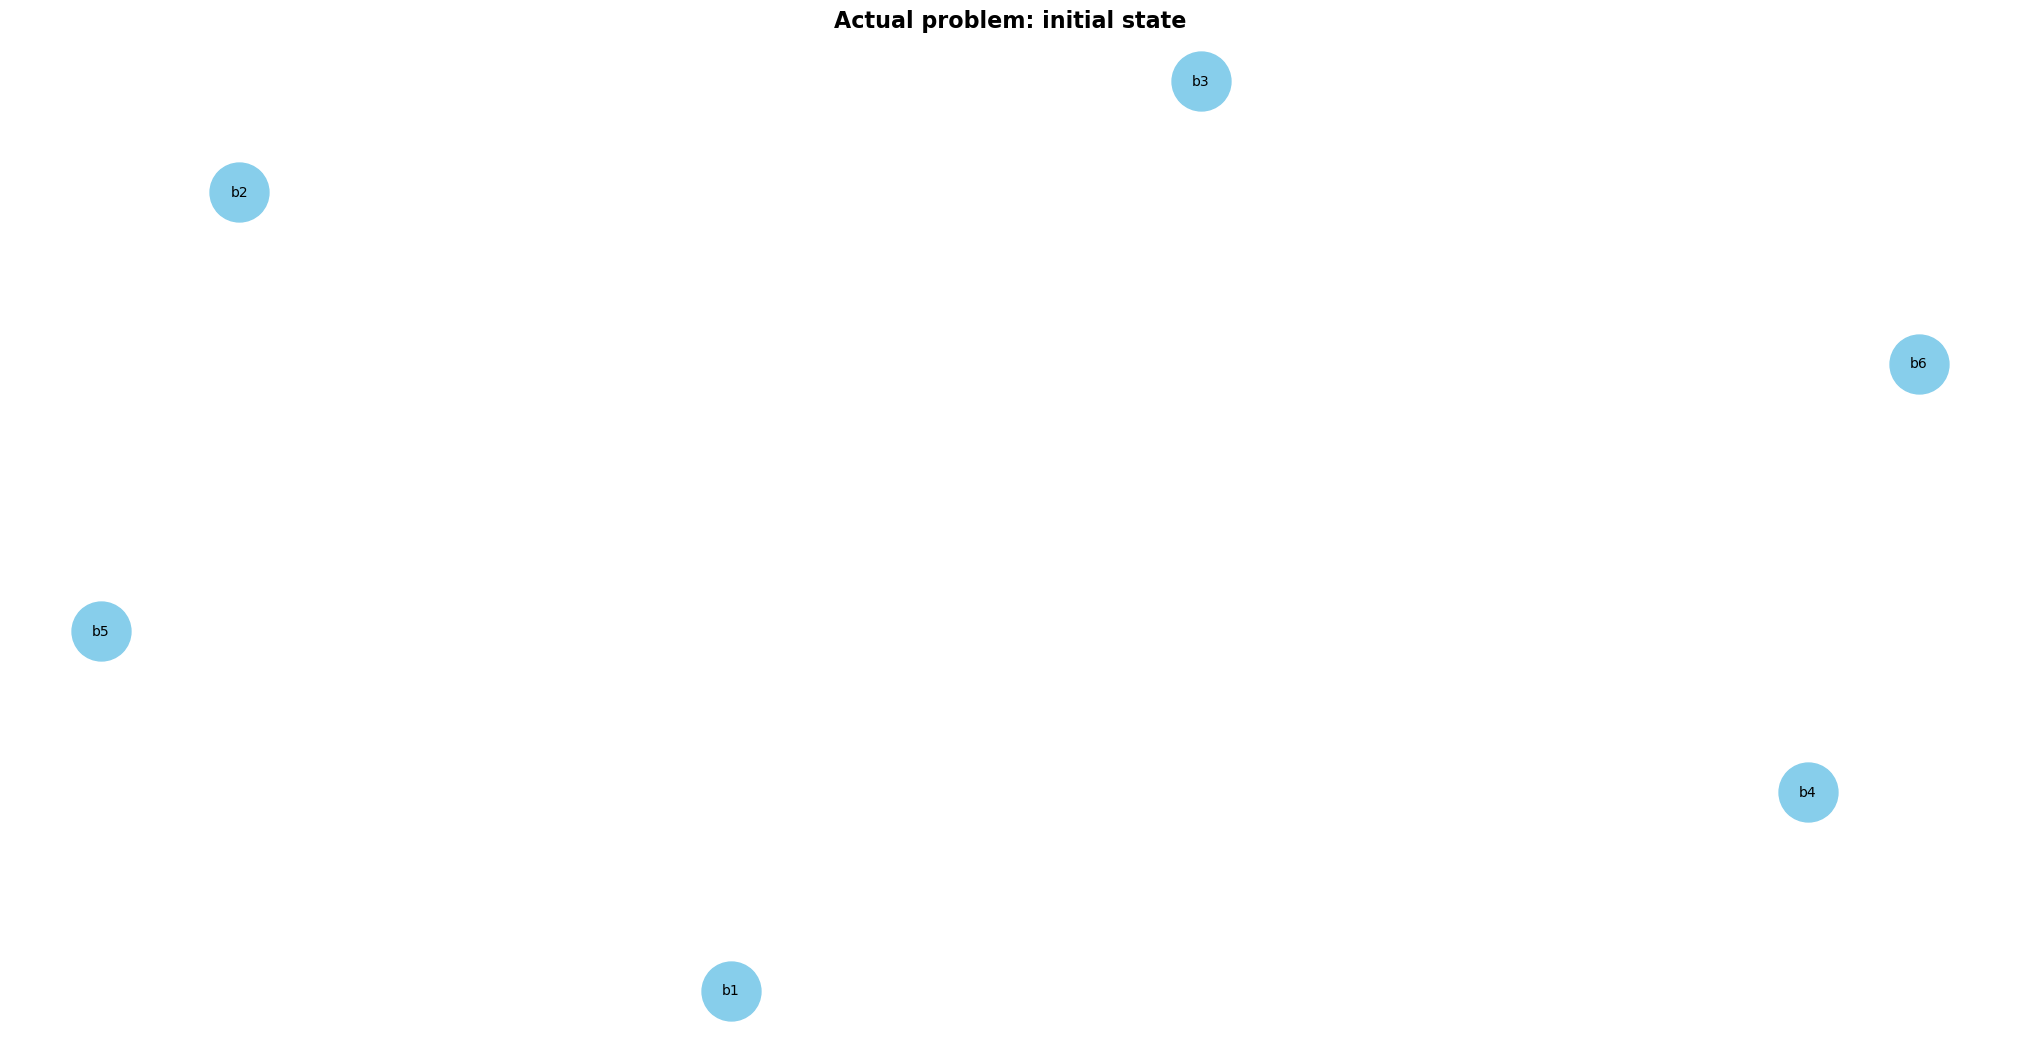

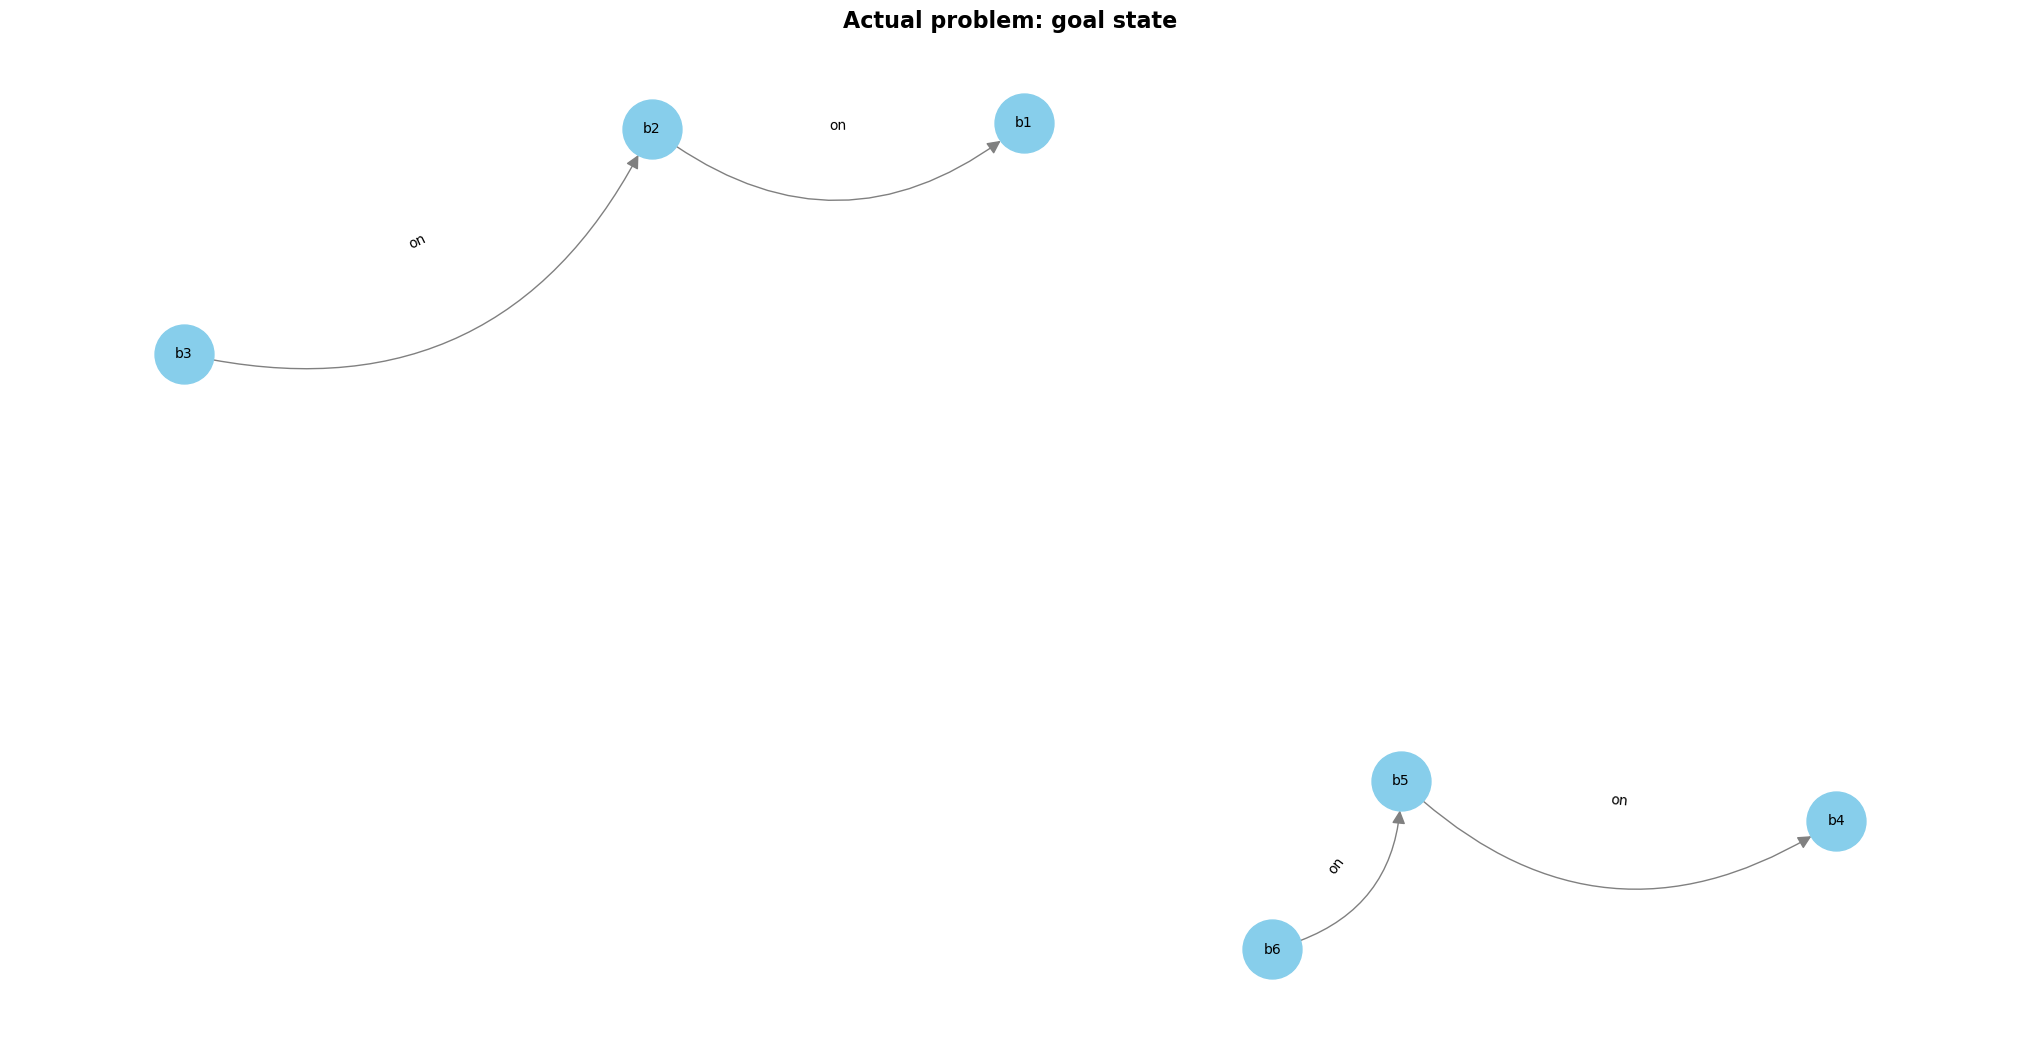

difference:  
4


In [35]:
curdir = "/home/asivak21/plai project/"
gt_problem_file = curdir + "problem2.pddl"
#gen_problem_file = curdir + "stack_blocks_problem.pddl"
domain_file = curdir + "blocksworld.pddl"

# Parse the PDDL files
gt_dp = parse_pddl(domain_file, gt_problem_file)
gen_dp = parse_pddl(domain_file, gen_problem_file)

# Extract predicates
gt_initial_predicates, gt_goal_predicates = get_predicates(gt_dp)
gen_initial_predicates, gen_goal_predicates = get_predicates(gen_dp)

# visualize graphs with arrows
G1 = visualize_scene_graph_with_arrows(gt_initial_predicates, 'Actual problem: initial state')
G2 = visualize_scene_graph_with_arrows(gt_goal_predicates, 'Actual problem: goal state')

# adjacency matrix 
adj1 = get_adjacency_matrix(G1)
adj2 = get_adjacency_matrix(G2)
print("difference:  ")
print(np.sum(np.abs(adj1-adj2)))

### Test actual code

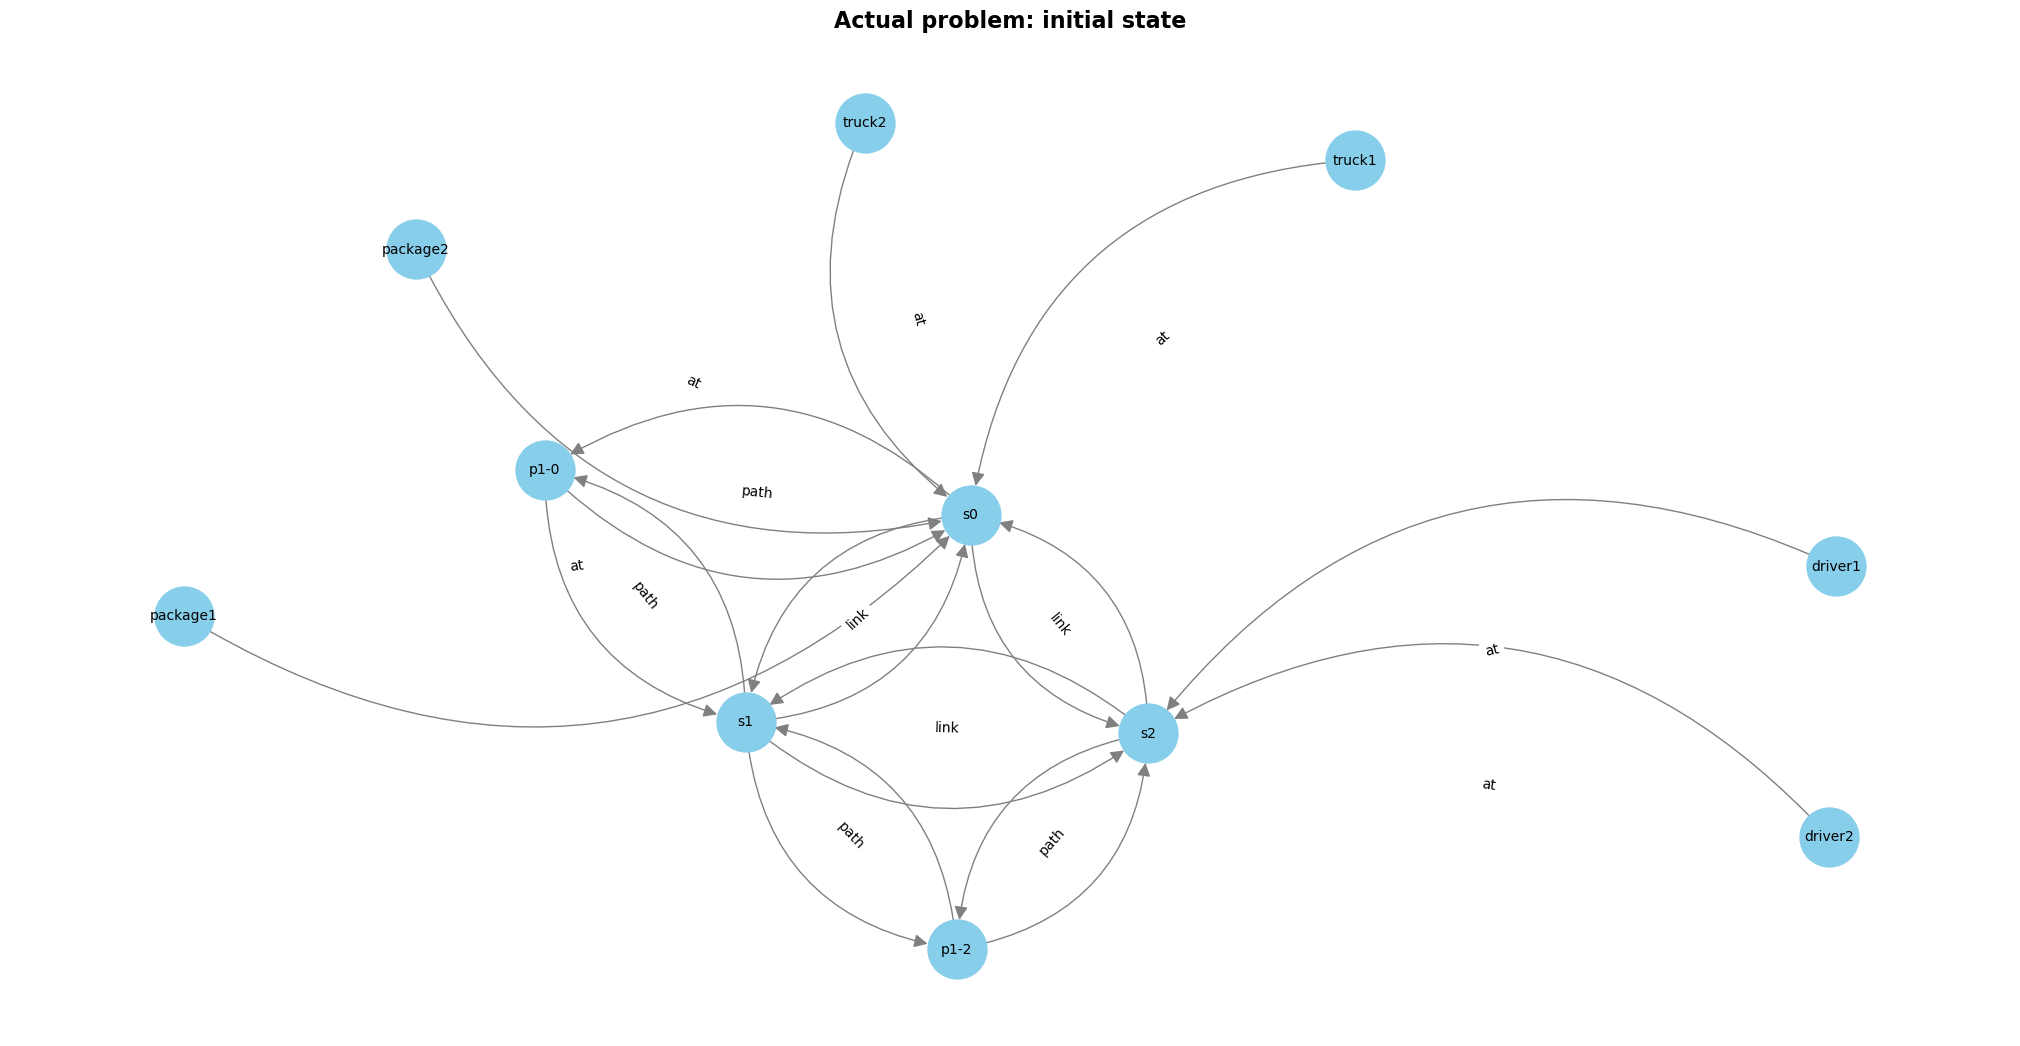

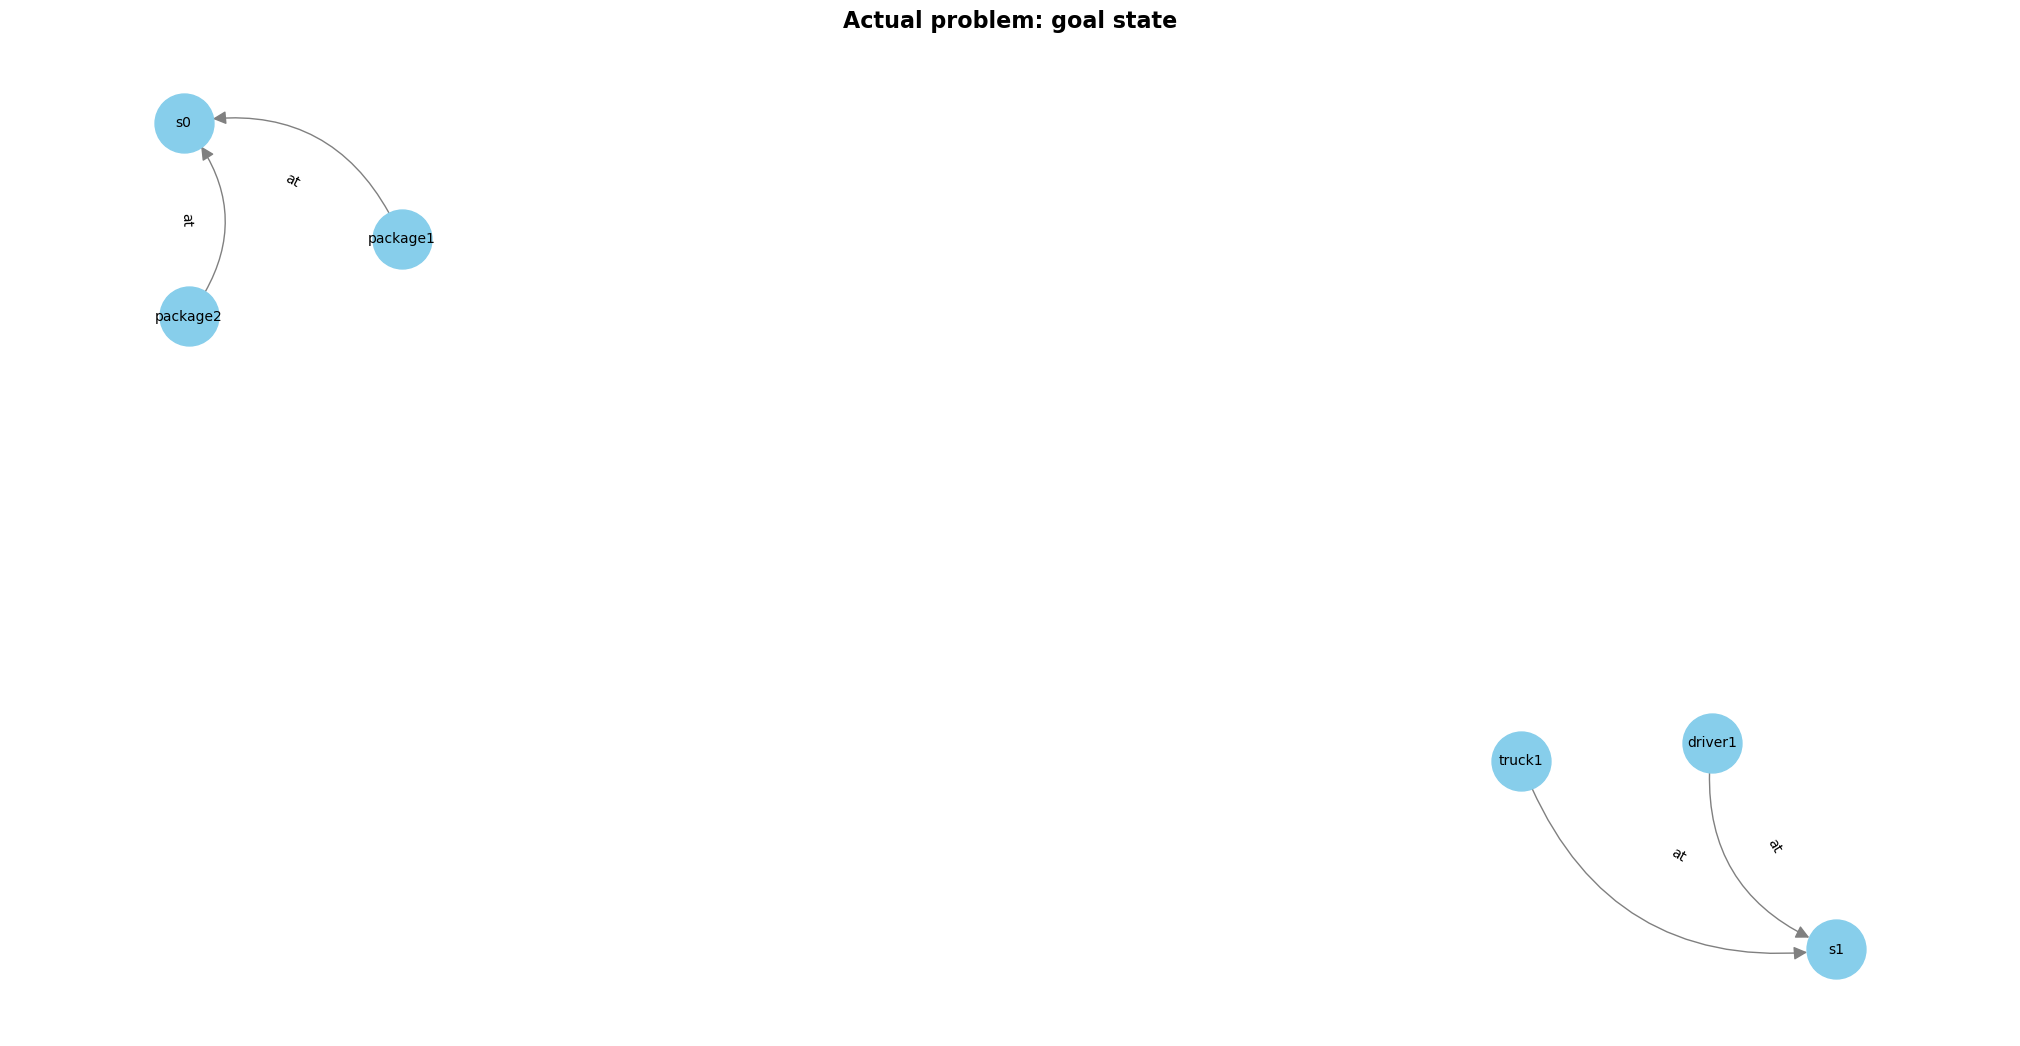

images saved
difference:  20


In [59]:
curdir = "/home/asivak21/plai project/"
domain_file = curdir + "second_actual_domain.pddl"
problem_file = curdir + "second_actual_problem.pddl"
output_file_init = "./output_images/sample_graph_init.png"
output_file_goal = "./output_images/sample_graph_goal.png"

gt_dp = parse_pddl(domain_file, problem_file)

gt_initial_predicates, gt_goal_predicates = get_predicates(gt_dp)

G1 = visualize_scene_graph_with_arrows(gt_initial_predicates, 'Actual problem: initial state', output_file=output_file_init)
G2 = visualize_scene_graph_with_arrows(gt_goal_predicates, 'Actual problem: goal state', output_file=output_file_goal)
print("images saved")

#compare_scene_graphs(G1, G2, 'dummy')

adj1, adj2, all_nodes = unify_adjacency_matrices(G1, G2)
#adj1 = get_adjacency_matrix(G1)
#adj2 = get_adjacency_matrix(G2)
#print("adj1: ")
#print(adj1)
#print("adj2: ")
#print(adj2)
diff = np.sum(np.abs(adj1-adj2))
print(f"difference:  {diff}")

dfres = pd.read_csv("output_file.csv")
dfres = pd.concat([dfres,pd.DataFrame([{
    "problem number": "1",
    "domain file": "second_actual_domain.pddl",
    "problem file": "second_actual_problem.pddl",
    "edit score": diff,
    "init scene graph path": output_file_init,
    "goal scene graph path": output_file_goal
}])], ignore_index=True)
dfres.to_csv("output_file.csv",index=False)

## Miscellaneous

### Extra adjacency matrix checking

In [42]:
import numpy as np
import networkx as nx

def get_adjacency_matrix(graph, all_nodes):
    """
    Computes the adjacency matrix for a directed graph, ensuring all nodes are included.

    Parameters:
    - graph: A NetworkX directed graph (DiGraph).
    - all_nodes: A list of all nodes that should be included in the matrix.

    Returns:
    - adjacency_matrix: A NumPy array representing the adjacency matrix.
    """
    # Ensure the nodes are in the same order
    nodes = sorted(all_nodes)

    # Create an empty adjacency matrix
    n = len(nodes)
    adjacency_matrix = np.zeros((n, n), dtype=int)

    # Populate the adjacency matrix
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if graph.has_edge(node1, node2):  # Check if there is an edge from node1 to node2
                adjacency_matrix[i, j] = 1

    return adjacency_matrix, nodes

def unify_adjacency_matrices(G1, G2):
    """
    Ensures the adjacency matrices for G1 and G2 have the same shape
    by including all nodes from both graphs in each matrix.

    Parameters:
    - G1: A NetworkX directed graph (DiGraph).
    - G2: A NetworkX directed graph (DiGraph).

    Returns:
    - adj1: Adjacency matrix for G1 with unified node set.
    - adj2: Adjacency matrix for G2 with unified node set.
    - all_nodes: List of all nodes in the unified set.
    """
    # Get the union of nodes from both graphs
    all_nodes = sorted(set(G1.nodes) | set(G2.nodes))

    # Compute the adjacency matrices with the unified node set
    adj1, nodes1 = get_adjacency_matrix(G1, all_nodes)
    adj2, nodes2 = get_adjacency_matrix(G2, all_nodes)

    return adj1, adj2, all_nodes



curdir = "/home/asivak21/plai project/"
domain_file = curdir + "second_actual_domain.pddl"
problem_file = curdir + "second_actual_problem.pddl"

gt_dp = parse_pddl(domain_file, problem_file)

gt_initial_predicates, gt_goal_predicates = get_predicates(gt_dp)

#G1 = visualize_scene_graph_with_arrows(gt_initial_predicates, 'Actual problem: initial state')
#G2 = visualize_scene_graph_with_arrows(gt_goal_predicates, 'Actual problem: goal state')

# Unify the adjacency matrices
adj1, adj2, all_nodes = unify_adjacency_matrices(G1, G2)
print(adj1.shape)
print(adj2.shape)
print("difference:  ")
print(np.sum(np.abs(adj1-adj2)))

(11, 11)
(11, 11)
difference:  
20


### Parseability Checking

In [43]:
curdir = "/home/asivak21/plai project/"
domain_file = curdir + "second_actual_domain.pddl"
problem_file = curdir + "parse_tester_problem.pddl"

gt_dp = parse_pddl(domain_file, problem_file)

gt_initial_predicates, gt_goal_predicates = get_predicates(gt_dp)

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc2 in position 582: ordinal not in range(128)

### PDDL file debugging

In [36]:
def detect_hidden_characters(file_path):
    with open(file_path, 'r') as file:
        for line_num, line in enumerate(file, start=1):
            for char_num, char in enumerate(line, start=1):
                if char in ['\t', '\n', '\r', '\f', '\v']:
                    print(f"Hidden character {repr(char)} found at Line {line_num}, Column {char_num}")

curdir = "/home/asivak21/plai project/"
domain_file = curdir + "actual_domain_cleaned2.pddl"
problem_file = curdir + "actual_problem_cleaned2.pddl"
print("for domain file, ")
detect_hidden_characters(domain_file)
print("\n\nfor problem file, ")
detect_hidden_characters(problem_file)

for domain file, 
Hidden character '\n' found at Line 1, Column 27
Hidden character '\n' found at Line 2, Column 33
Hidden character '\n' found at Line 3, Column 46
Hidden character '\n' found at Line 4, Column 30
Hidden character '\n' found at Line 5, Column 13
Hidden character '\n' found at Line 6, Column 38
Hidden character '\n' found at Line 7, Column 30
Hidden character '\n' found at Line 8, Column 33
Hidden character '\n' found at Line 9, Column 48
Hidden character '\n' found at Line 10, Column 19
Hidden character '\n' found at Line 11, Column 2
Hidden character '\n' found at Line 12, Column 46
Hidden character '\n' found at Line 13, Column 35
Hidden character '\n' found at Line 14, Column 9
Hidden character '\n' found at Line 15, Column 10
Hidden character '\n' found at Line 16, Column 20
Hidden character '\n' found at Line 17, Column 12
Hidden character '\n' found at Line 18, Column 12
Hidden character '\n' found at Line 19, Column 15
Hidden character '\n' found at Line 20, Col

In [31]:
def remove_hidden_characters(file_path, output_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Process each line: remove unwanted characters and trim spaces
    # .replace('\t', '').
    cleaned_lines = [line.replace('\n', '').strip() for line in lines if line.strip()]

    # Write the cleaned lines back to the output file
    with open(output_path, 'w') as file:
        file.write('\n'.join(cleaned_lines))

# Paths to your original and cleaned files
curdir = "/home/asivak21/plai project/"
domain_file = curdir + "actual_domain_cleaned.pddl"
problem_file = curdir + "actual_problem_cleaned.pddl"
domain_file_clean = curdir + "actual_domain_cleaned2.pddl"
problem_file_clean = curdir + "actual_problem_cleaned2.pddl"

# Clean both PDDL files
remove_hidden_characters(domain_file, domain_file_clean)
remove_hidden_characters(problem_file, problem_file_clean)

print("Hidden characters removed. Cleaned files saved.")


Hidden characters removed. Cleaned files saved.


### Original code (for reference)

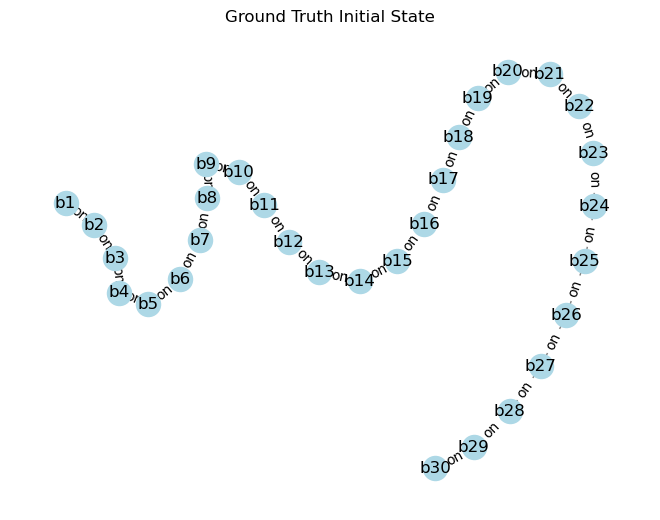

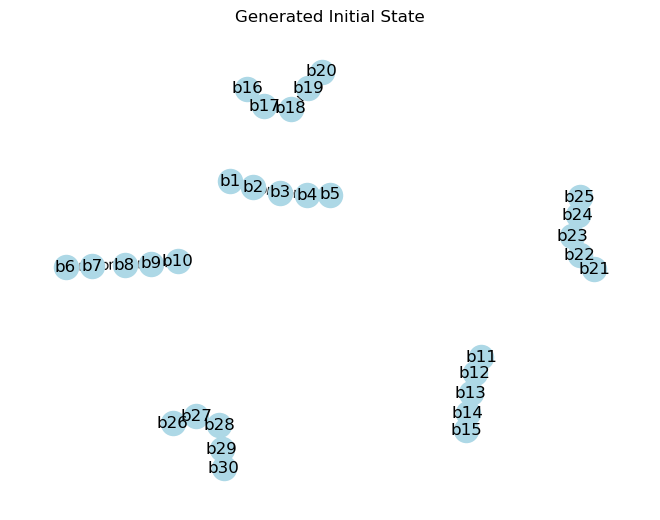

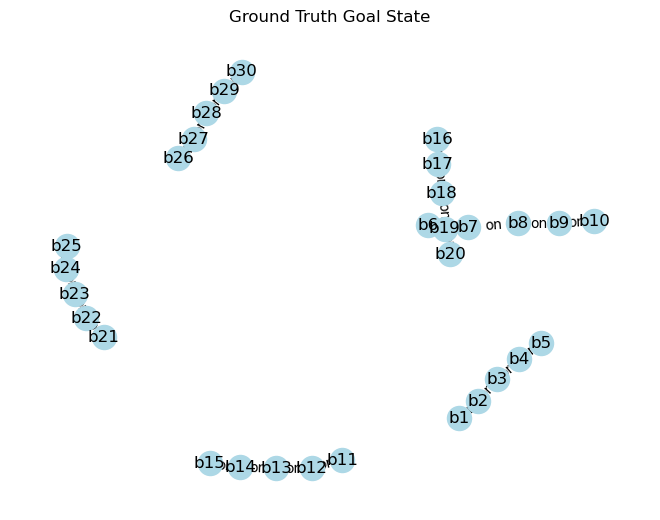

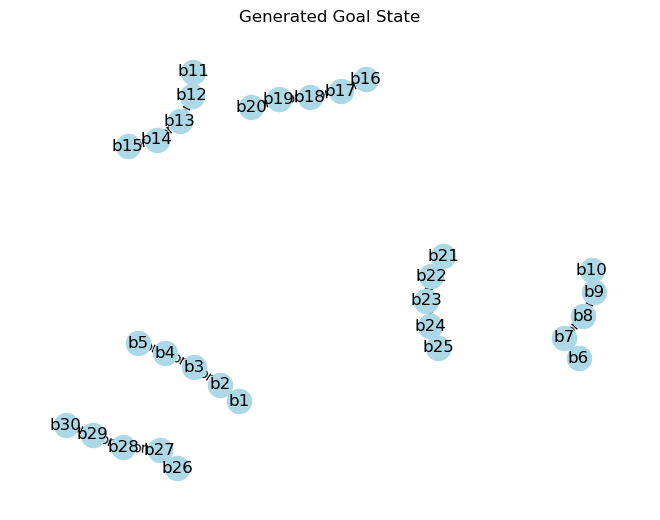

In [14]:
curdir = "/home/asivak21/plai project/"

#gt_domain_file = 'path/to/ground_truth_domain.pddl'
gt_problem_file = curdir + "sample_problem_groundtruth.pddl"
#gen_domain_file = 'path/to/generated_domain.pddl'
gen_problem_file = curdir + "stack_blocks_problem.pddl"
domain_file = curdir + "blocksworld.pddl"

# Parse the PDDL files
gt_dp = parse_pddl(domain_file, gt_problem_file)
gen_dp = parse_pddl(domain_file, gen_problem_file)

# Extract predicates
gt_initial_predicates, gt_goal_predicates = get_predicates(gt_dp)
gen_initial_predicates, gen_goal_predicates = get_predicates(gen_dp)

# # Build scene graphs
#gt_initial_graph = build_scene_graph(gt_initial_predicates)
#gen_initial_graph = build_scene_graph(gen_initial_predicates)

#gt_goal_graph = build_scene_graph(gt_goal_predicates)
#gen_goal_graph = build_scene_graph(gen_goal_predicates)

# # Visualize scene graphs
#visualize_scene_graph(gt_initial_graph, 'Ground Truth Initial State')
#visualize_scene_graph(gen_initial_graph, 'Generated Initial State')

#visualize_scene_graph(gt_goal_graph, 'Ground Truth Goal State')
#visualize_scene_graph(gen_goal_graph, 'Generated Goal State')

#gt_initial_graph = visualize_scene_graph_with_arrows(gt_initial_predicates, 'Ground Truth: Initial State')
#gen_initial_graph = visualize_scene_graph_with_arrows(gen_initial_predicates, 'Generated: Initial State')
#
#gt_goal_graph = visualize_scene_graph_with_arrows(gt_goal_predicates, 'Ground Truth: Goal State')
#gen_goal_graph = visualize_scene_graph_with_arrows(gen_goal_predicates, 'Generated: Goal State')
#
# Compare scene graphs
#compare_scene_graphs(gt_initial_graph, gen_initial_graph, 'initial state')
#compare_scene_graphs(gt_goal_graph, gen_goal_graph, 'goal state')

### Initial code for dataframe

In [58]:
columns = {
    "problem number": str,
    "domain file": str,
    "problem file": str,
    "edit score": int,
    "init scene graph path": str,
    "goal scene graph path": str
}

# Create the empty DataFrame
df = pd.DataFrame(columns=columns.keys()).astype(columns)

df.to_csv('output_file.csv',index=False)